# Import
Nothing special, KMeans for quick clustering (Needs to implement mediods :( ) 
Axes3D used for 3D, better to run in terminal because you can interact with it!

In [21]:
import matplotlib
import numpy as np
import scipy.stats as sc
import pandas as pd
import matplotlib.pyplot as plt
import copy as cp
from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D
from random import randint
from sklearn.linear_model import LogisticRegression
import seaborn as sns

## Review data, Business data and User data
We're reducing our data here initially to save on loading space.

In [58]:
review_fields = ['review_id', 'user_id', 'business_id', 'stars', 'date'] #text
business_fields = ['business_id', 'name', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'categories', 'is_open']
user_fields = ['user_id', 'name', 'review_count', 'average_stars']

# Create the dataframes
review and user dataframes are gonna be HUGE so we should chunk them, and for now just use a sample to solidify ideas

In [23]:
business_df = pd.read_csv("yelp_business.csv", usecols=business_fields)
hours_df = pd.read_csv("yelp_business_hours.csv")
review_chunks = pd.read_csv("yelp_review.csv",usecols=review_fields,chunksize=500000)
users = pd.read_csv("yelp_user.csv", usecols=user_fields, chunksize=500000)

In [24]:
## TODO: Put everyone's cleaning code in here!

In [25]:
class Sampleable:
    def __init__(self, sample):
        self.sample = self.__mutate(sample)
        assert isinstance(self.sample, pd.core.frame.DataFrame)
        self.sample.dropna()
        self.sample_size = 0
            
    def __mutate(self, sample):
        if isinstance(sample, pd.io.parsers.TextFileReader):
            for s in sample: sample = s; break
        return sample
    
    def getType(self):
        return self.type
    
    def getSample(self, n_samples):
        self.sample_size = n_samples
        rows = np.random.choice(self.sample.index.values, n_samples)
        return self.sample.iloc[rows]
    
    def getOrderedSample(self, n_samples):
        return self.sample.head(n_samples)
    
    def randomMutate(self, new_sample):
        self.sample = self.__mutate(new_sample)
    
businessSampler = Sampleable(business_df)
hoursSampler = Sampleable(hours_df)
reviewSampler = Sampleable(review_chunks)
userSampler = Sampleable(users)

# It's important to use these `Sampleable`
Objects to get samples, methods return a dataframe to work with and have methods for quick resampling

In [26]:
b_samp = businessSampler.getSample(5000)
h_samp = hoursSampler.getSample(1000)
r_samp = reviewSampler.getSample(1000)
u_samp = userSampler.getSample(1000)
u_samp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 28764 to 411033
Data columns (total 4 columns):
user_id          1000 non-null object
name             1000 non-null object
review_count     1000 non-null int64
average_stars    1000 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 39.1+ KB


### The Sample Size
Feel free to use something else, but just to start illustrating a point 1000 will be fine?

In [27]:
class GraphInfoObject2D:
    def __init__(self, title, x_vars, y_vars):
        self.title = title
        self.x = x_vars[0]
        self.y = y_vars[0]
        self.xlabel = x_vars[1]
        self.ylabel = y_vars[1]
        self.primary_color = 'yellow'
        self.secondary_color = 'purple'
        self.tertiary_color = 'blue'
    def getTitle(self):
        return self.title
    def getXLabel(self):
        return self.xlabel
    def getYLabel(self):
        return self.ylabel
    def getColor(self,level):
        if(level == 1):
            return self.primary_color
        elif(level == 2):
            return self.secondary_color
        elif(level == 3):
            return self.tertiary_color
        return self.primary_color
    def setColor(self, level, color):
        if(level == 1):
            self.primary_color = color
        elif(level == 2):
            self.secondar_color = color
        else:
            self.tertiary_color = color

class Graph2DScatter:
    def __init__(self, GIO, x_data, y_data, size=(10,10)):
        self.fig = plt.figure(figsize=size)
        self.ax = self.fig.add_subplot(111)
        self.GIO = GIO
        self.data = (x_data, y_data)
        self.size = size
        self.icon_size = size[0] * size[1] + 75
        
    def create(self):
        self.ax.scatter(self.data[0], self.data[1],c=self.GIO.getColor(1),marker='o')
        self.ax.set_title(self.GIO.getTitle())
        self.ax.set_xlabel(self.GIO.getXLabel())
        self.ax.set_ylabel(self.GIO.getYLabel())
        
    def display(self):
        plt.show()
        
    def create_additional(self, x_data, y_data, color_labels=False, labels=None, colors=[], marker='o',s=10):
        if(color_labels and labels is not None):
            if(labels is None or colors == []): print("ERROR: Labels not assigned!"); return
            self.ax.scatter(x_data, y_data, c=labels, cmap=matplotlib.colors.ListedColormap(colors), marker=marker)
        elif(colors is not None):
            self.ax.scatter(x_data, y_data, cmap=matplotlib.colors.ListedColormap(colors), marker=marker,s=s)
        else:
            self.ax.scatter(x_data, y_data, c=self.GIO.getColor(1), marker=marker, s=s)            
        self.ax.set_title(self.GIO.getTitle())
        self.ax.set_xlabel(self.GIO.getXLabel())
        self.ax.set_ylabel(self.GIO.getYLabel())
        
    def getFigAx(self):
        return (self.fig, self.ax)


## Let's first look at Latitude vs Longitude for Business Locations

In [60]:
b_samp = businessSampler.getSample(150000)
b_samp2 = businessSampler.getSample(150000)
lats = b_samp['latitude'].dropna()
longs = b_samp['longitude'].dropna()

lats = pd.concat([b_samp['latitude'], b_samp2['latitude']], axis=0).dropna()
longs = pd.concat([b_samp['longitude'], b_samp2['longitude']], axis=0).dropna()

## Also to adhere to the graphing function, we have to make a graph info object

In [61]:
title = ''.join(['Latitude vs. Longitude for Businesses (', str(len(lats)), ' samples)'])
GIO_Business = GraphInfoObject2D(title, (lats, 'Latitude'), (longs, 'Longitude'))
GIO_Business.setColor(1,'purple')

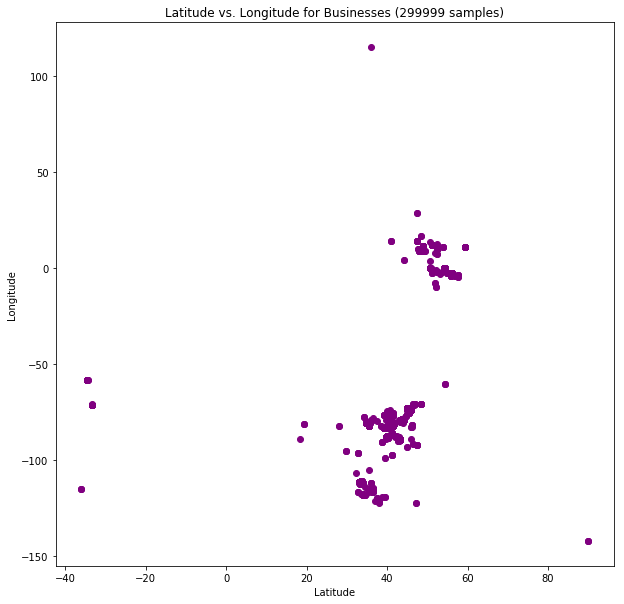

In [62]:
graph = Graph2DScatter(GIO_Business, lats, longs)
graph.create()
graph.display()

# Before we start graphing with KMeans, let's make a KMeans object for graphing using `GraphInfoObject2D`

In [63]:
X = []
for item in zip(lats,longs):
    X.append([item[0], item[1]])

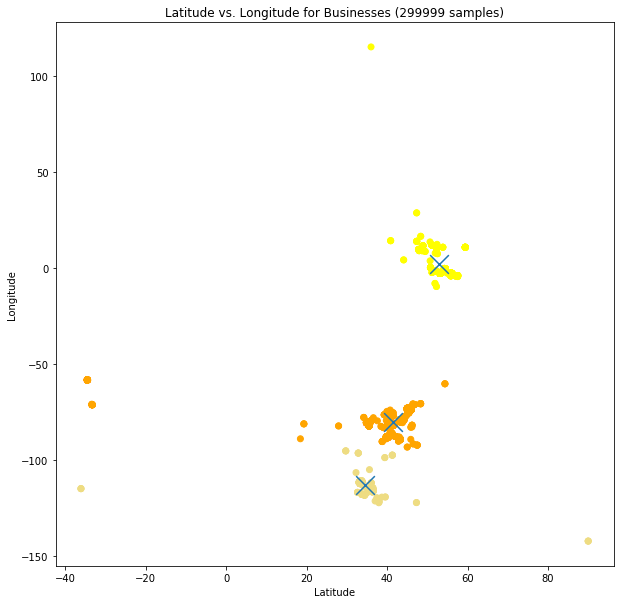

In [64]:
graph = Graph2DScatter(GIO_Business, lats, longs)
GIO_Business.setColor(1, '#7e084b')
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
centroids = kmeans.cluster_centers_
colors = ['#eedc82', 'yellow', 'orange']

graph.create_additional(lats, longs, color_labels=True, labels=kmeans.labels_, colors=colors, marker='o')
graph.create_additional(centroids[:,0], centroids[:,1], color_labels=False, labels=None, colors=[], marker='x',s=350)
graph.display()

In [65]:
print(centroids)

[[  34.51432538 -113.22797375]
 [  53.03809423    1.81518388]
 [  41.5357435   -80.26255264]]


In [34]:
b_samp = businessSampler.getSample(100000)
review_count = b_samp['review_count']
stars = b_samp['stars']

In [35]:
title = ''.join(['Review Count vs Star Rating (', str(reviewSampler.sample_size), ' samples)'])
GIO_CountvStars = GraphInfoObject2D(title, (review_count, 'Review Count'), (stars, 'Stars'))
GIO_CountvStars.setColor(1,'purple')

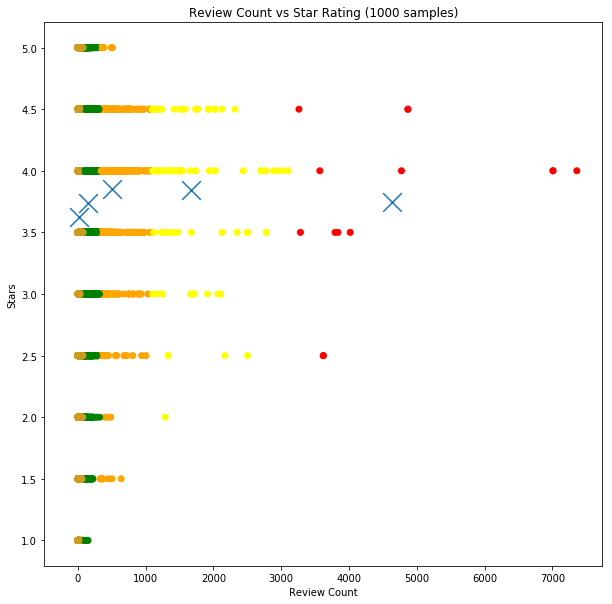

In [36]:
X = []
for item in zip(review_count,stars):
    X.append([item[0], item[1]])
    
graph = Graph2DScatter(GIO_CountvStars, review_count, stars)

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

centroids = kmeans.cluster_centers_
colors = ['#cd9b1d', 'yellow', 'orange', 'green', 'red']

graph.create_additional(review_count, stars, color_labels=True, labels=kmeans.labels_, colors=colors, marker='o')
graph.create_additional(centroids[:,0], centroids[:,1], color_labels=False, labels=None, colors=[], marker='x',s=350)
graph.display()

In [37]:
print(centroids)

[[1.41635559e+01 3.62530044e+00]
 [1.67604124e+03 3.84020619e+00]
 [4.99219439e+02 3.84919840e+00]
 [1.47640613e+02 3.73724138e+00]
 [4.63564286e+03 3.75000000e+00]]


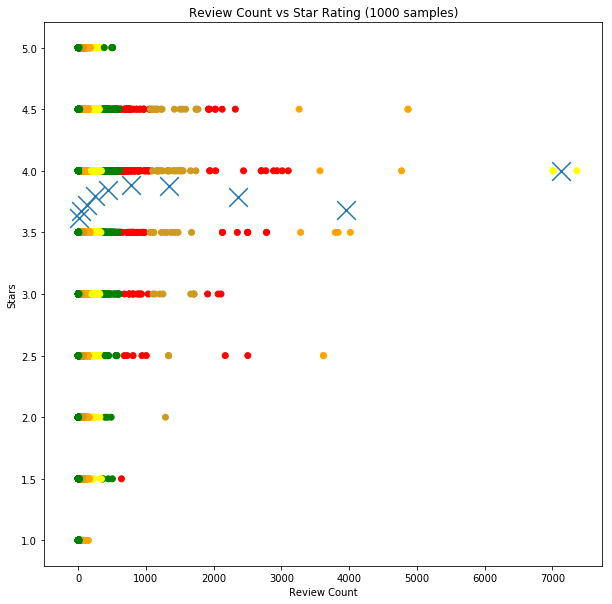

In [38]:
X = []
for item in zip(review_count,stars):
    X.append([item[0], item[1]])
    
graph = Graph2DScatter(GIO_CountvStars, review_count, stars)

kmeans = KMeans(n_clusters=10)
kmeans.fit(X)

centroids = kmeans.cluster_centers_
colors = ['#cd9b1d', 'yellow', 'orange', 'green', 'red']

graph.create_additional(review_count, stars, color_labels=True, labels=kmeans.labels_, colors=colors, marker='o')
graph.create_additional(centroids[:,0], centroids[:,1], color_labels=False, labels=None, colors=[], marker='x',s=350)
graph.display()

In [39]:
print(centroids)

[[4.87186796e+01 3.67130808e+00]
 [1.33447887e+03 3.87323944e+00]
 [2.48585424e+02 3.79719235e+00]
 [7.12633333e+03 4.00000000e+00]
 [3.95636364e+03 3.68181818e+00]
 [1.23621284e+02 3.72112548e+00]
 [4.44111450e+02 3.84122137e+00]
 [8.67088831e+00 3.61792411e+00]
 [2.36074194e+03 3.79032258e+00]
 [7.79545000e+02 3.88500000e+00]]


In [40]:
b_samp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 144062 to 82433
Data columns (total 11 columns):
business_id     100000 non-null object
name            100000 non-null object
city            100000 non-null object
state           100000 non-null object
postal_code     99679 non-null object
latitude        100000 non-null float64
longitude       100000 non-null float64
stars           100000 non-null float64
review_count    100000 non-null int64
is_open         100000 non-null int64
categories      100000 non-null object
dtypes: float64(3), int64(2), object(6)
memory usage: 11.7+ MB


In [41]:
is_open = b_samp['is_open']

In [42]:
title = ''.join(['Average Rating vs Is Open (', str(businessSampler.sample_size), ' samples)'])
GIO_StarsVOpen = GraphInfoObject2D(title, (stars, 'Review Count'), (is_open, 'Open'))
GIO_StarsVOpen.setColor(1,'purple')

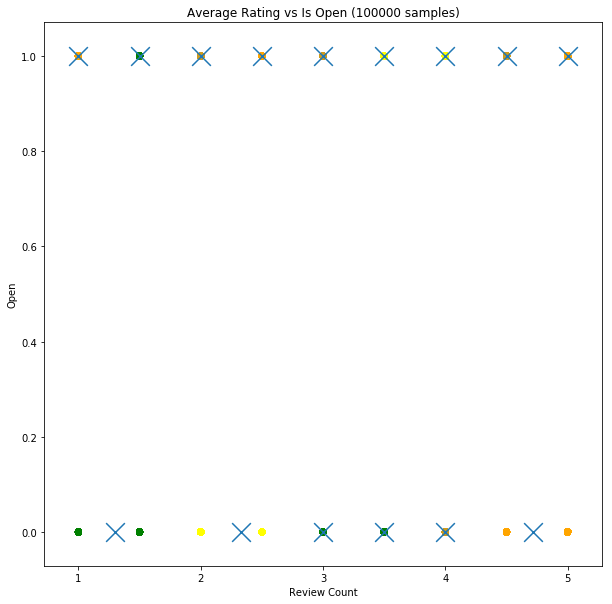

In [43]:
X = []
for item in zip(stars,is_open):
    X.append([item[0], item[1]])
    
graph = Graph2DScatter(GIO_StarsVOpen, stars, is_open)

kmeans = KMeans(n_clusters=15)
kmeans.fit(X)

centroids = kmeans.cluster_centers_
colors = ['#cd9b1d', 'yellow', 'orange', 'green']

graph.create_additional(stars, is_open, color_labels=True, labels=kmeans.labels_, colors=colors, marker='o')
graph.create_additional(centroids[:,0], centroids[:,1], color_labels=False, labels=None, colors=[], marker='x',s=350)
graph.display()

In [44]:
centroids
total_x, total_y = 0,0
for each in centroids:
    total_x += each[0]
    total_y += each[1]
print(total_x/15,total_y/15)

3.0560829638637634 0.6000000000000367


# May not seem interesting but...
What we can gain from this is that the average cluster lands around 3 stars and is usually open. We could think about using logistic regression or something similar here!

In [47]:
b_samp = businessSampler.getSample(5000)
stars = b_samp['stars']
is_open = b_samp['is_open']
data = pd.concat([stars, is_open], axis=1)
sns.regplot(x='stars', y='is_open', data=data, logistic=True)

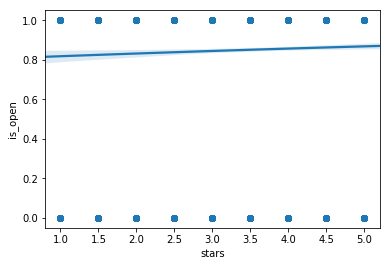

In [48]:
plt.show()

## Nothing...
Too interesting about the logreg withe stars and being open (not shutdown)
As a reminder here are the attributes for other dataframes

In [49]:
b_samp.info() # from businessSampler
h_samp.info() # from hoursSampler
r_samp.info() # from reviewSampler
u_samp.info() # from userSampler

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 71108 to 51588
Data columns (total 11 columns):
business_id     5000 non-null object
name            5000 non-null object
city            5000 non-null object
state           5000 non-null object
postal_code     4984 non-null object
latitude        5000 non-null float64
longitude       5000 non-null float64
stars           5000 non-null float64
review_count    5000 non-null int64
is_open         5000 non-null int64
categories      5000 non-null object
dtypes: float64(3), int64(2), object(6)
memory usage: 468.8+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 30690 to 166442
Data columns (total 8 columns):
business_id    1000 non-null object
monday         1000 non-null object
tuesday        1000 non-null object
wednesday      1000 non-null object
thursday       1000 non-null object
friday         1000 non-null object
saturday       1000 non-null object
sunday         1000 non-null object
dtypes: object(8

In [50]:
r_samp = reviewSampler.getOrderedSample(1000000)
b_samp = businessSampler.getOrderedSample(1000000)
review_star_business = r_samp[['business_id','stars']]
business_locations = b_samp[['business_id', 'latitude', 'longitude']]
df_final = pd.merge(business_locations.dropna(), review_star_business.dropna(), on='business_id')

In [51]:
lats = df_final['latitude']
longs = df_final['longitude']
stars = df_final['stars']

In [52]:
business_locations.head(20)
print(df_final.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 499997 entries, 0 to 499996
Data columns (total 4 columns):
business_id    499997 non-null object
latitude       499997 non-null float64
longitude      499997 non-null float64
stars          499997 non-null int64
dtypes: float64(2), int64(1), object(1)
memory usage: 19.1+ MB
None


In [53]:
class GraphInfoObject3D(GraphInfoObject2D):
    def __init__(self, title, x_vars, y_vars, z_vars):
        super().__init__(title, x_vars, y_vars)
        self.z = z_vars[0]
        self.zlabel = z_vars[1]
    
    def getZLabel(self):
        return self.zlabel
    
class Graph3DScatter:
    def __init__(self, GIO, x_data, y_data, z_data, size=(10,10)):
        self.fig = plt.figure(figsize=size)
        self.ax = self.fig.add_subplot(111, projection='3d')
        self.GIO = GIO
        self.data = (x_data, y_data, z_data)
        self.size = size
        self.icon_size = size[0] * size[1] + 75
        
    def create(self):
        self.ax.scatter(self.data[0], self.data[1], self.data[2], c=self.GIO.getColor(1),marker='o')
        self.ax.set_title(self.GIO.getTitle())
        self.ax.set_xlabel(self.GIO.getXLabel())
        self.ax.set_ylabel(self.GIO.getYLabel())
        self.ax.set_zlabel(self.GIO.getZLabel())
        
    def display(self):
        plt.show()
        
    def create_additional(self, x_data, y_data, z_data, color_labels=False, labels=None, colors=[], marker='o',s=10):
        if(color_labels and labels is not None):
            if(labels is None or colors == []): print("ERROR: Labels not assigned!"); return
            self.ax.scatter(x_data, y_data, z_data, c=labels, cmap=matplotlib.colors.ListedColormap(colors), marker=marker)
        elif(colors is not None):
            self.ax.scatter(x_data, y_data, z_data, cmap=matplotlib.colors.ListedColormap(colors), marker=marker,s=s)
        else:
            self.ax.scatter(x_data, y_data, z_data, c=self.GIO.getColor(1), marker=marker, s=s)            
        self.ax.set_title(self.GIO.getTitle())
        self.ax.set_xlabel(self.GIO.getXLabel())
        self.ax.set_ylabel(self.GIO.getYLabel())
        self.ax.set_zlabel(self.GIO.getZLabel())

    def getFigAx(self):
        return (self.fig, self.ax)


In [54]:
title = ''.join(['Business Location vs Review Given (', str(len(r_samp)), ' samples)'])
GIO3D = GraphInfoObject3D(title, (lats, 'Latitude'), (longs, 'Longitude'), (stars, 'Stars'))
GIO3D.setColor(1,'purple')

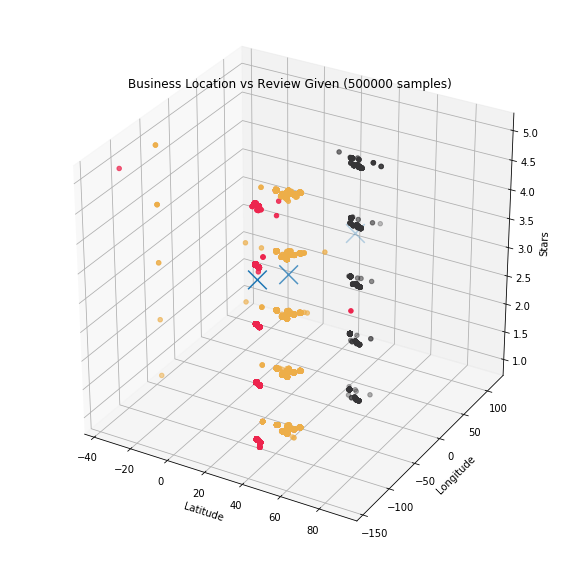

In [55]:
X = []
for item in zip(lats,longs,stars):
    X.append([item[0], item[1],item[2]])
    
graph = Graph3DScatter(GIO3D, lats, longs, stars)

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

centroids = kmeans.cluster_centers_
colors = ['#ED254E', '#F9DC5C', '#C2EABD', '#502419', '#EDAE49', '#00798C', '#2E86AB', '#363537']
graph.create_additional(lats, longs, stars, color_labels=True, labels=kmeans.labels_, colors=colors, marker='o')
graph.create_additional(centroids[:,0], centroids[:,1], centroids[:,2], color_labels=False, labels=None, colors=[], marker='x',s=350)
graph.display()

In [57]:
print(centroids)

[[  34.86893599 -113.66590445    3.7697973 ]
 [  41.39570242  -80.43068026    3.65743818]
 [  53.00962611    1.94298822    3.82844558]]


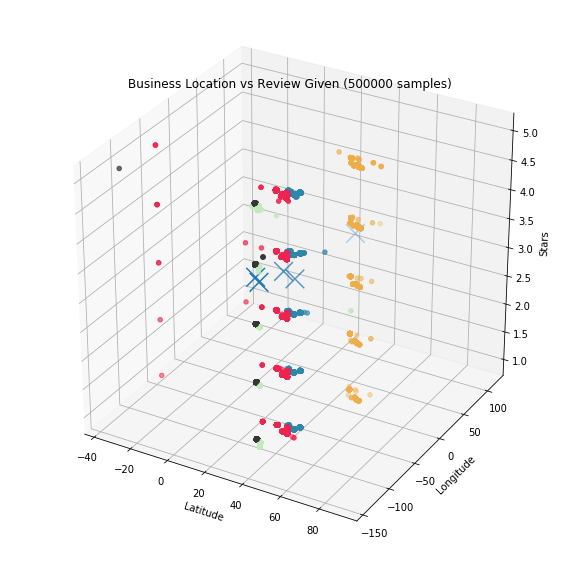

In [201]:
graph = Graph3DScatter(GIO3D, lats, longs, stars)

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

centroids = kmeans.cluster_centers_
colors = ['#ED254E', '#F9DC5C', '#C2EABD', '#502419', '#EDAE49', '#00798C', '#2E86AB', '#363537']
graph.create_additional(lats, longs, stars, color_labels=True, labels=kmeans.labels_, colors=colors, marker='o')
graph.create_additional(centroids[:,0], centroids[:,1], centroids[:,2], color_labels=False, labels=None, colors=[], marker='x',s=350)
graph.display()

In [202]:
print(centroids)

[[  39.27012749  -82.14541873    3.70754021]
 [  36.11534763 -115.1823565     3.75327124]
 [  53.00962611    1.94298822    3.82844558]
 [  44.03681201  -78.30028939    3.59520306]
 [  33.48695497 -111.98466365    3.78811246]]


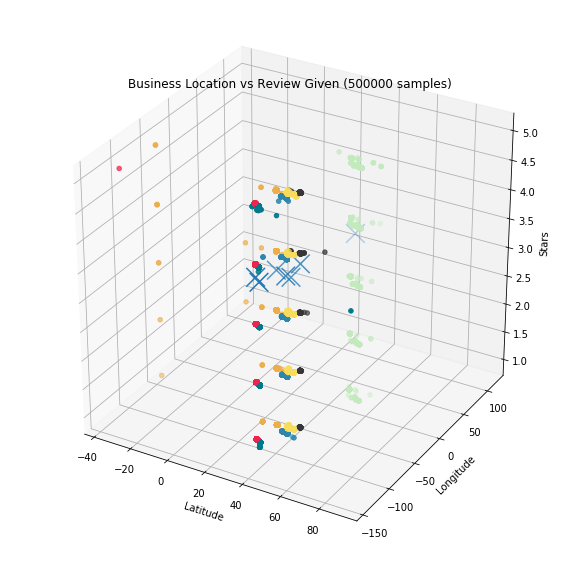

In [203]:
graph = Graph3DScatter(GIO3D, lats, longs, stars)

kmeans = KMeans(n_clusters=7)
kmeans.fit(X)

centroids = kmeans.cluster_centers_
colors = ['#ED254E', '#F9DC5C', '#C2EABD', '#502419', '#EDAE49', '#00798C', '#2E86AB', '#363537']
graph.create_additional(lats, longs, stars, color_labels=True, labels=kmeans.labels_, colors=colors, marker='o')
graph.create_additional(centroids[:,0], centroids[:,1], centroids[:,2], color_labels=False, labels=None, colors=[], marker='x',s=350)
graph.display()

In [210]:
print(centroids)

[[  33.48696726 -111.98495887    3.78810839]
 [  42.49828506  -80.06717169    3.62176558]
 [  53.00962611    1.94298822    3.82844558]
 [  35.16514313  -80.8285588     3.67988688]
 [  36.11534763 -115.1823565     3.75327124]
 [  42.38062102  -89.13459272    3.71316592]
 [  45.50917582  -73.59109225    3.82464974]]


33.48696726, -111.98495887 - Scottsdale, Arizona

42.49828506, -80.06717169  - Lake Erie

53.00962611, 1.94298822    - In the UK???

35.16514313, -80.8285588   - Charlotte South Carolina

36.11534763, -115.1823565  - Las Vegas, Nevada

42.38062102, -89.13459272  - Rockford, Illinois (Lake Michigan)

45.50917582, -73.59109225  - Montreal, Canada

In [66]:
u_samp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 28764 to 411033
Data columns (total 4 columns):
user_id          1000 non-null object
name             1000 non-null object
review_count     1000 non-null int64
average_stars    1000 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 39.1+ KB


In [219]:
r_samp = reviewSampler.getOrderedSample(1000000)
b_samp = businessSampler.getOrderedSample(1000000)
review_star_business = u_samp[['business_id','stars']]
business_locations = b_samp[['business_id', 'latitude', 'longitude']]
df_final = pd.merge(business_locations.dropna(), review_star_business.dropna(), on='business_id')